In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import itertools
import statsmodels.api as sm
import warnings
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data=pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True)

In [3]:
data

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


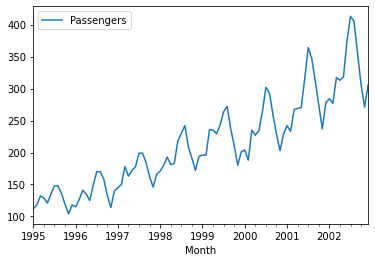

In [4]:
#lineplot
data.plot()
plt.show()

#trend + multiplicative seasonality

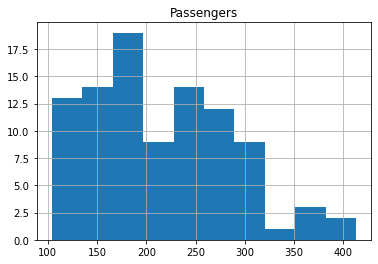

In [5]:
#Histogram plot 
data.hist()
plt.show()

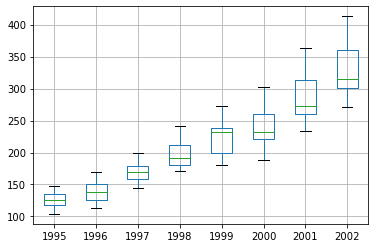

In [6]:
data=pd.read_excel('Airlines+Data.xlsx',header=0,squeeze=True,index_col=0,parse_dates=True)
groups =data.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.values
years.boxplot()
plt.show()

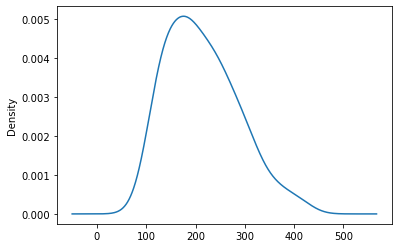

In [7]:
#density plot 
data.plot(kind='kde')

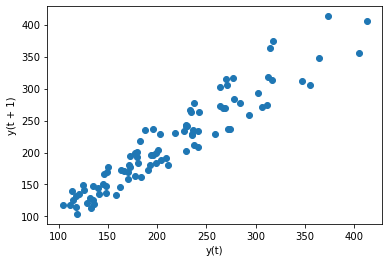

In [8]:
pd.plotting.lag_plot(data)

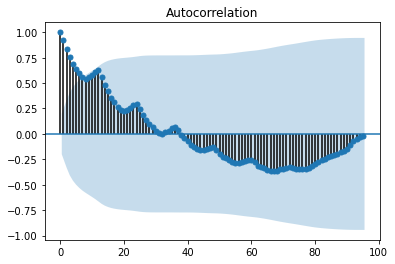

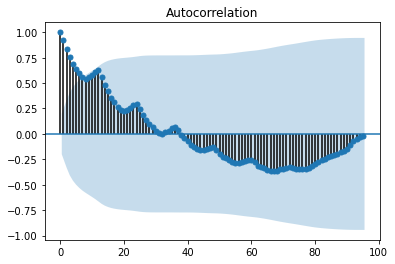

In [9]:
plot_acf(data,lags=95)

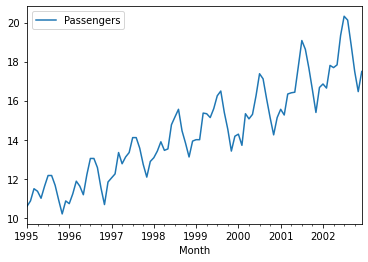

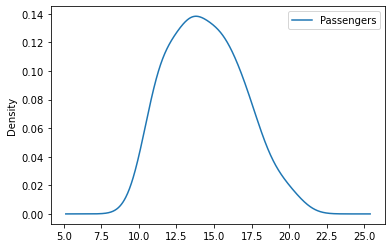

In [10]:
data=pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True)
# applying 2nd order polynomial transformation
data1=data.copy()
data1.columns=['Passengers']
data1["Passengers"]=np.sqrt(data1['Passengers'])
data1.plot()
data1.plot(kind='kde')
plt.show()

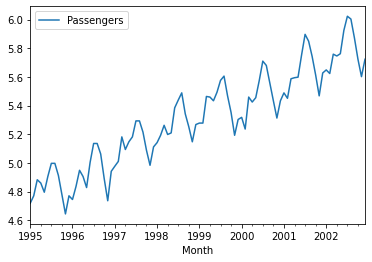

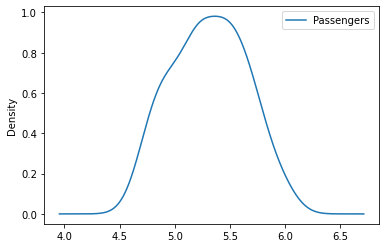

In [11]:
data2=data.copy()
data2.columns=["Passengers"]
data2['Passengers']=np.log(data2['Passengers'])
data2.plot()
data2.plot(kind='kde')

#log transformation seems to give more accurate normal distribution

In [12]:
#Applying log transformation
data["log_Passengers"]=np.log(data["Passengers"])
data=data.reset_index()

In [13]:
#extracting month and year
data["month"]=data.Month.dt.strftime("%b")
data["year"]=data.Month.dt.strftime("%Y")

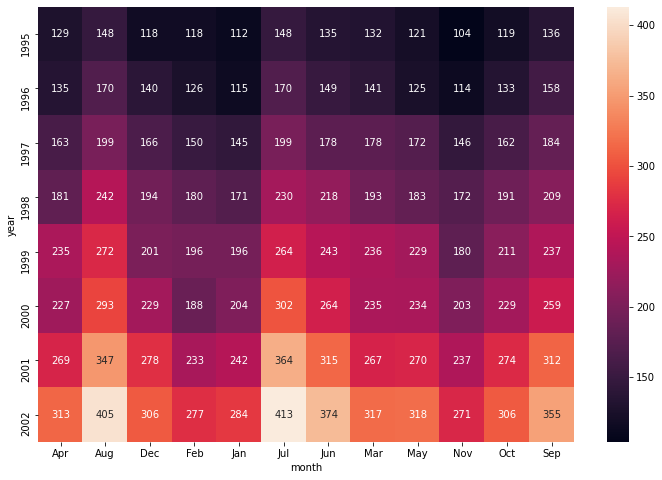

In [14]:
#Heat map
plt.figure(figsize=(12,8))
heatmap_Y_month=pd.pivot_table(data=data,values="Passengers",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_Y_month,annot=True,fmt='g')

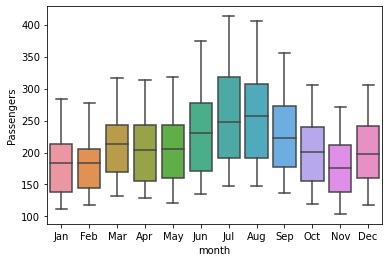

In [15]:
sns.boxplot(x="month",y="Passengers",data=data)

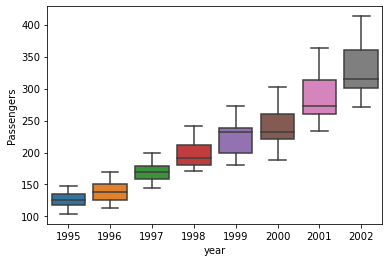

In [16]:
sns.boxplot(x="year",y="Passengers",data=data)

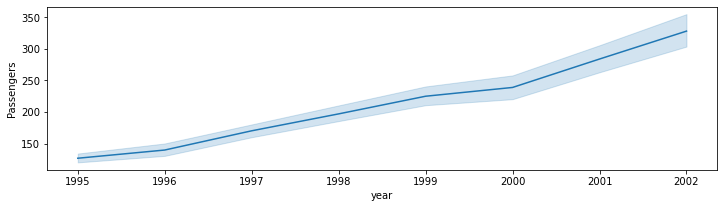

In [17]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year", y="Passengers", data=data)

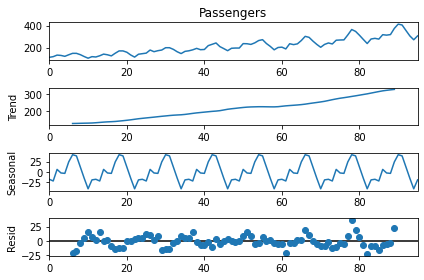

In [18]:
decompose_ts_add=seasonal_decompose(data.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

In [19]:
month_dummies=pd.DataFrame(pd.get_dummies(data["month"]))
data=pd.concat([data,month_dummies],axis=1)

In [20]:
data["t"]=np.arange(1,97)
data["t_square"]=data["t"]*data["t"]

In [21]:
data

,Month,Passengers,log_Passengers,month,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_square
0,1995-01-01,112,4.718499,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,1995-02-01,118,4.770685,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0,2,4
2,1995-03-01,132,4.882802,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0,3,9
3,1995-04-01,129,4.859812,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0,4,16
4,1995-05-01,121,4.795791,May,1995,0,0,0,0,0,0,0,0,1,0,0,0,5,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2002-08-01,405,6.003887,Aug,2002,0,1,0,0,0,0,0,0,0,0,0,0,92,8464
92,2002-09-01,355,5.872118,Sep,2002,0,0,0,0,0,0,0,0,0,0,0,1,93,8649
93,2002-10-01,306,5.723585,Oct,2002,0,0,0,0,0,0,0,0,0,0,1,0,94,8836
94,2002-11-01,271,5.602119,Nov,2002,0,0,0,0,0,0,0,0,0,1,0,0,95,9025


In [22]:
Train=data.head(80)
Test=data.tail(16)
Train

,Month,Passengers,log_Passengers,month,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_square
0,1995-01-01,112,4.718499,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0,1,1
1,1995-02-01,118,4.770685,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0,2,4
2,1995-03-01,132,4.882802,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0,3,9
3,1995-04-01,129,4.859812,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0,4,16
4,1995-05-01,121,4.795791,May,1995,0,0,0,0,0,0,0,0,1,0,0,0,5,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2001-04-01,269,5.594711,Apr,2001,1,0,0,0,0,0,0,0,0,0,0,0,76,5776
76,2001-05-01,270,5.598422,May,2001,0,0,0,0,0,0,0,0,1,0,0,0,77,5929
77,2001-06-01,315,5.752573,Jun,2001,0,0,0,0,0,0,1,0,0,0,0,0,78,6084
78,2001-07-01,364,5.897154,Jul,2001,0,0,0,0,0,1,0,0,0,0,0,0,79,6241


RMSE_Linear_Model: 47.542624067726734


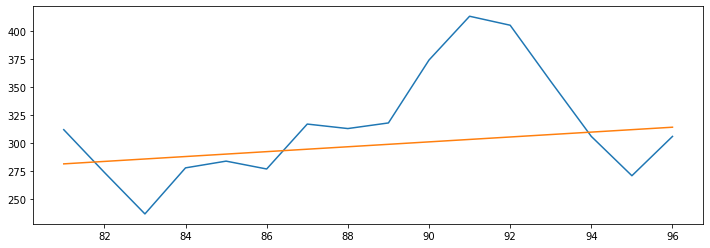

In [23]:
#linear Model
plt.figure(figsize=(12,4))
linear_model=smf.ols("Passengers~t",data=Train).fit()
pred_linear=pd.Series(linear_model.predict(Test['t']))
rmse_linear=np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_linear))**2))
print("RMSE_Linear_Model:",rmse_linear)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_linear)
plt.show()

RMSE_Exponential_Model: 43.79373939334322


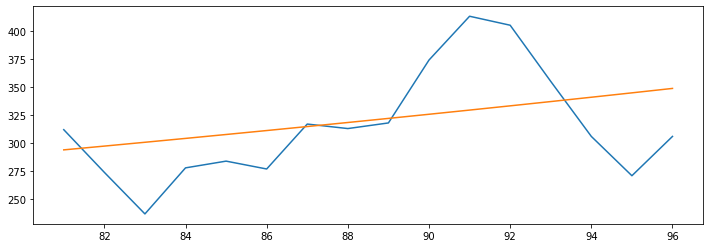

In [24]:
#Exponential
plt.figure(figsize=(12,4))
Exp= smf.ols("log_Passengers~t",data=Train).fit()
pred_Exp= pd.Series(Exp.predict(Test["t"]))
pred_Exp=np.exp(pred_Exp)
rmse_Exp= np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_Exp))**2))
print("RMSE_Exponential_Model:",rmse_Exp)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_Exp)
plt.show()

RMSE_Qudratic_Model: 47.542624067726734


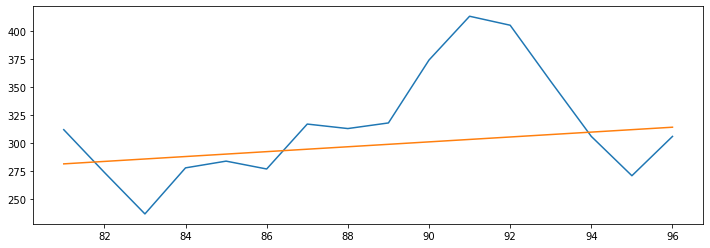

In [25]:
#Quadratic
plt.figure(figsize=(12,4))
Quad=smf.ols("Passengers~t+(t**2)",data=Train).fit()
pred_Quad= pd.Series(Quad.predict(Test["t"]))
rmse_Quad=np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_Quad))**2))
print("RMSE_Qudratic_Model:",rmse_Quad)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_Quad)
plt.show()

RMSE_Additive Seasonality Model: 129.266476414433


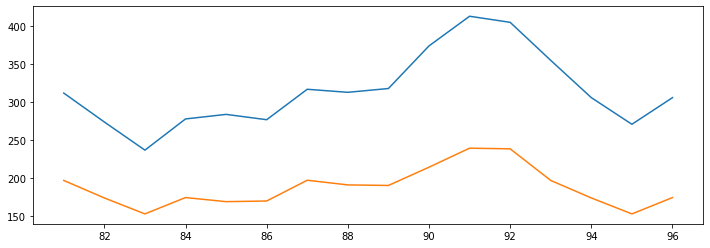

In [26]:
# Additive seasonality
plt.figure(figsize=(12,4))
add_sea= smf.ols("Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec",data=Train).fit()
pred_add_sea= pd.Series(add_sea.predict(Test[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]]))
rmse_add_se=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
print("RMSE_Additive Seasonality Model:",rmse_add_se)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_add_sea)
plt.show()

RMSE_Multiplicative Seasonality: 135.32648414621053


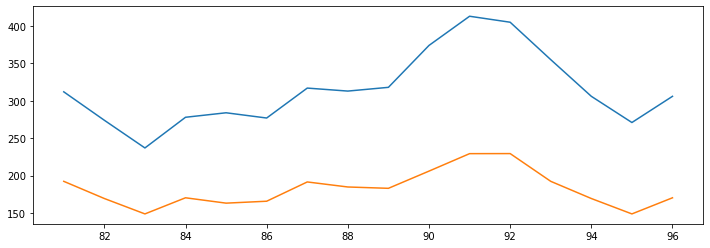

In [27]:
#Multiplicative seasonality
plt.figure(figsize=(12,4))
Mul_sea= smf.ols("log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec",data=Train).fit()
pred_Mult_sea= pd.Series(Mul_sea.predict(Test[["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]]))
pred_Mult_sea=np.exp(pred_Mult_sea)
rmse_Mult_se=np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Mult_sea))**2))
print("RMSE_Multiplicative Seasonality:",rmse_Mult_se)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_Mult_sea)
plt.show()

RMSE_Additive_seasonality_Quadratic: 17.944501734411997


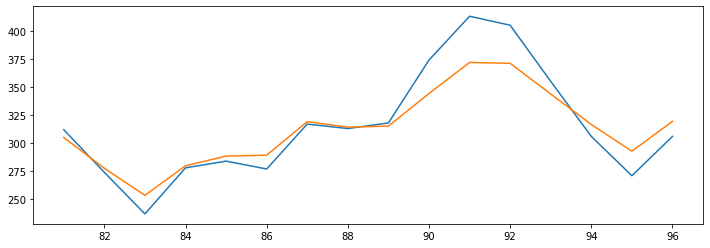

In [28]:
#Additive seasonality Quadratic
plt.figure(figsize=(12,4))
add_sea_quad=smf.ols("Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec",data=data).fit()
pred_add_sea_quad=pd.Series(add_sea_quad.predict(Test[["t","t_square","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]]))
rmse_add_sea_quad= np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_add_sea_quad))**2))
print("RMSE_Additive_seasonality_Quadratic:",rmse_add_sea_quad)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_add_sea_quad)
plt.show()

RMSE_Additive_seasonality_Linear: 22.27505092729916


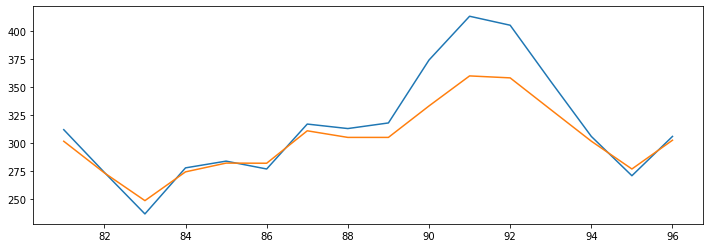

In [29]:
#Additive seasonality linear
plt.figure(figsize=(12,4))
add_sea_lin=smf.ols("Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec",data=data).fit()
pred_add_sea_lin=pd.Series(add_sea_lin.predict(Test[["t","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]]))
rmse_add_sea_lin= np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_add_sea_lin))**2))
print("RMSE_Additive_seasonality_Linear:",rmse_add_sea_lin)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_add_sea_lin)
plt.show()

RMSE_Multiplicative_seasonality_Quadratic 9.212541460841006


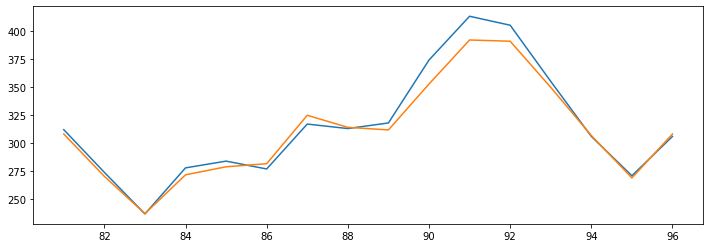

In [30]:
# Multiplicative Seasonality Quadratic
plt.figure(figsize=(12,4))
Mul_sea_quad=smf.ols("log_Passengers~t+t_square+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec",data=data).fit()
pred_Mul_sea_quad=pd.Series(Mul_sea_quad.predict(Test[["t","t_square","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]]))
pred_Mul_sea_quad=np.exp(pred_Mul_sea_quad)
rmse_Mul_sea_quad= np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_Mul_sea_quad))**2))
print("RMSE_Multiplicative_seasonality_Quadratic",rmse_Mul_sea_quad)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_Mul_sea_quad)
plt.show()

RMSE_Multiplicative_seasonality_linear 7.997346072375827


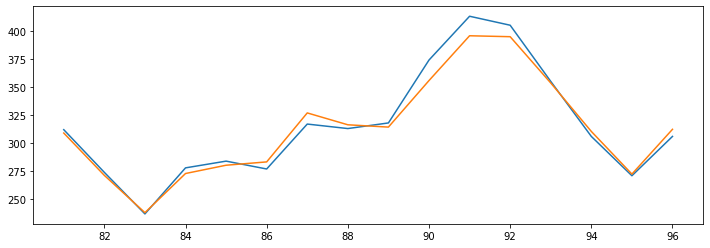

In [31]:
#linear Multiplicative seasonality
plt.figure(figsize=(12,4))
Mul_sea_lin=smf.ols("log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec",data=data).fit()
pred_Mul_sea_lin=pd.Series(Mul_sea_lin.predict(Test[["t","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]]))
pred_Mul_sea_lin=np.exp(pred_Mul_sea_lin)
rmse_Mul_sea_lin= np.sqrt(np.mean((np.array(Test["Passengers"])-np.array(pred_Mul_sea_lin))**2))
print("RMSE_Multiplicative_seasonality_linear",rmse_Mul_sea_lin)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_Mul_sea_lin)
plt.show()

RMSE_Moving_Average 20.101694580308397


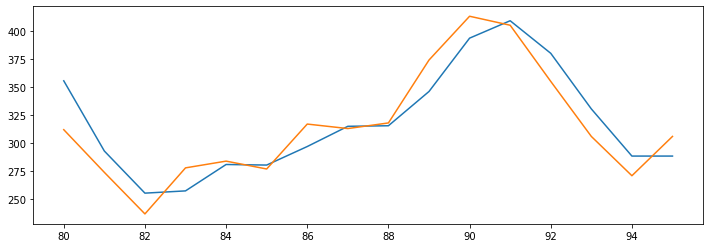

In [32]:
#Moving Average model

plt.figure(figsize=(12,4))
A=Test["Passengers"].rolling(2).mean()
A[80]=(Train.Passengers[79]+Train.Passengers[78])/2
RMSE=np.sqrt(mean_squared_error(Test["Passengers"],A))
print("RMSE_Moving_Average",RMSE)
A.plot()
Test.Passengers.plot(label="org")
plt.show()

ACF and PACF plot

C:\Users\MRITYUNJAY\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


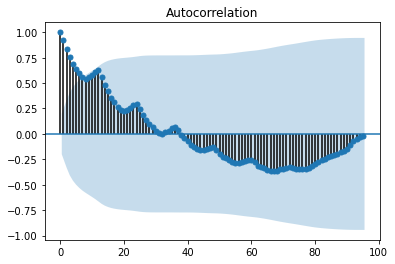

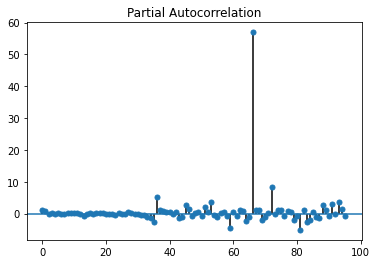

In [33]:
plot_acf(data.Passengers,lags=95)
plot_pacf(data.Passengers,lags=95)
plt.show()

RMSE_Simple_Exponential_Method 48.005443238938966


C:\Users\MRITYUNJAY\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


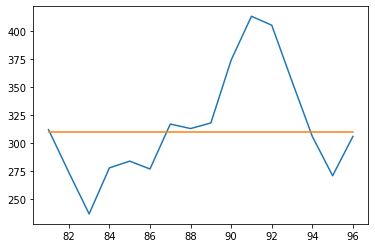

In [34]:
#Simple Exopnential Method
ses_model=SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=2)
pred_ses=ses_model.predict(start=Test.index[0],end=Test.index[-1])
RMSE_SM=np.sqrt(mean_squared_error(Test["Passengers"],pred_ses))
print("RMSE_Simple_Exponential_Method",RMSE_SM)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_ses)
plt.show()

C:\Users\MRITYUNJAY\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


RMSE_Holt_Method 44.80386551904883


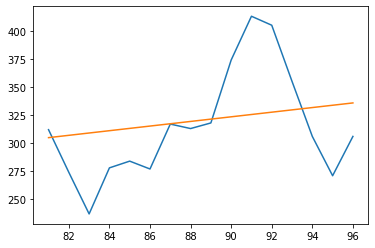

In [35]:
#Holt method

hw_model=Holt(Train["Passengers"]).fit(smoothing_level=1.75,smoothing_slope=0.20)
pred_hw=hw_model.predict(start=Test.index[0],end=Test.index[-1])
RMSE_HM=np.sqrt(mean_squared_error(Test["Passengers"],pred_hw))
print("RMSE_Holt_Method",RMSE_HM)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_hw)
plt.show()

RMSE_Holt_Winter_Additive_Method 26.813055819551654


C:\Users\MRITYUNJAY\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\MRITYUNJAY\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\MRITYUNJAY\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warn("Optimization failed to converge. Check mle_retvals.",


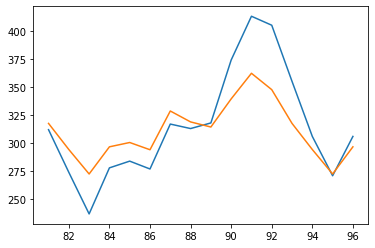

In [36]:
#Holts Winter exponential smoothing with additive seasonality and additive trend
hwe_model_add=ExponentialSmoothing(Train["Passengers"],seasonal="add",seasonal_periods=12).fit()
pred_hwe_ad=hwe_model_add.predict(start=Test.index[0],end=Test.index[-1])
RMSE_pred_hwe=np.sqrt(mean_squared_error(Test["Passengers"],pred_hwe_ad))
print("RMSE_Holt_Winter_Additive_Method",RMSE_pred_hwe)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_hwe_ad)
plt.show()

C:\Users\MRITYUNJAY\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\MRITYUNJAY\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


RMSE_Holt_Winter_Multiplicative_Method 7.1740730626219245


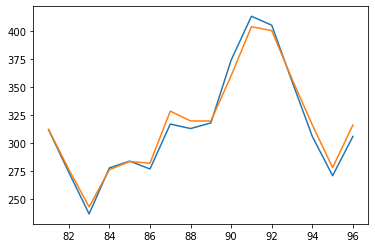

In [37]:
#Holts Winter exponential smoothing with multiplicative seasonality and multiplicative trend
hwe_model_mul= ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="mul",seasonal_periods=12).fit() 
pred_hwe_mul = hwe_model_mul.predict(start = Test.index[0],end = Test.index[-1])
RMSE_hwe_mul=np.sqrt(mean_squared_error(Test["Passengers"],pred_hwe_mul))
print("RMSE_Holt_Winter_Multiplicative_Method",RMSE_hwe_mul)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],pred_hwe_mul)
plt.show()

# Arima model

In [38]:
test=Test.Passengers.astype('float32')
train=Train.Passengers.astype('float32')
m=float('inf')

In [39]:
x=4
y=4
z=4
warnings.filterwarnings("ignore")
for i in range(0,x,1):
    for j in range(0,y,1):
        for k in range(0,z,1):
            try:
                model=ARIMA(train,order=(i,j,k))
                model=model.fit()
                RM=model.predict(start = test.index[0],end = test.index[-1])
                RMSE=np.sqrt(mean_squared_error(test,RM))
                order=(i,j,k)
                print(order,RMSE)
                if RMSE<m :
                    m=RMSE
                    best_order=(i,j,k)
            except:
                continue


            


(0, 0, 0) 130.58484789591787
(0, 0, 1) 128.16976142698465
(0, 0, 2) 125.90136096211944
(0, 0, 3) 126.53642245191537
(0, 1, 0) 315.6545550269746
(0, 1, 1) 316.18835820907555
(0, 1, 2) 316.463645718698
(0, 1, 3) 320.54613027150054
(0, 2, 0) 318.88690186356763
(0, 2, 1) 317.16699330849065
(0, 2, 2) 317.23057469933315
(0, 2, 3) 317.2454403748878
(1, 0, 0) 56.770951594363176
(1, 0, 1) 73.77633552446441
(1, 0, 2) 60.80969942423233
(1, 0, 3) 3461.1514477951305
(1, 1, 0) 315.9337875321701
(1, 1, 1) 315.89714928907534
(1, 1, 2) 320.1767155363362
(1, 1, 3) 320.2070138991802
(1, 2, 0) 317.7855876355381
(1, 2, 1) 317.19685676593315
(1, 2, 2) 317.21950841835786
(1, 2, 3) 317.2290698417528
(2, 0, 0) 72.96101963738447
(2, 0, 2) 70.02512579551853
(2, 1, 0) 316.4582586279202
(2, 1, 1) 320.38871759020964
(2, 1, 2) 316.5834204866647
(2, 2, 0) 316.79082111512986
(2, 2, 1) 317.2876031039872
(2, 2, 2) 317.2274945133712
(3, 0, 0) 61.37521944070391
(3, 0, 1) 70.07628997791768
(3, 0, 2) 33.38880104626172
(3, 0

In [40]:
m,best_order

(33.38880104626172, (3, 0, 2))

RMSE_Arima_Model_ 33.38880104626172


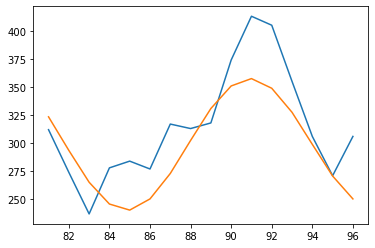

In [41]:
model=ARIMA(Train['Passengers'],order=(3,0,2))
model=model.fit()
RM=model.predict(start = Test.index[0],end = Test.index[-1])
RMSE=np.sqrt(mean_squared_error(Test["Passengers"],RM))
print("RMSE_Arima_Model_",RMSE)
plt.plot(Test["t"],Test["Passengers"])
plt.plot(Test["t"],RM)
plt.show()

# Final model based on Best Model
training on full dataset

RMSE_Holt_Winter_Multiplicative_Method 8.126136829740918


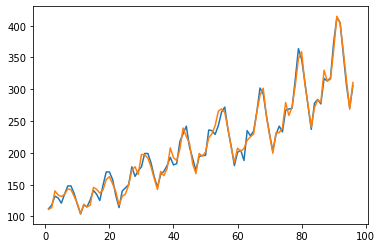

In [42]:
#Holts Winter exponential smoothing with multiplicative seasonality and multiplicative trend
hwe_model_mul= ExponentialSmoothing(data["Passengers"],seasonal="mul",trend="mul",seasonal_periods=12).fit() 
pred_hwe_mul = hwe_model_mul.predict(start = data.index[0],end = data.index[-1])
RMSE_hwe_mul=np.sqrt(mean_squared_error(data["Passengers"],pred_hwe_mul))
print("RMSE_Holt_Winter_Multiplicative_Method",RMSE_hwe_mul)
plt.plot(data["t"],data["Passengers"])
plt.plot(data["t"],pred_hwe_mul)
plt.show()